In [1]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, utils, callbacks
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
#from tensorflow.keras import layers
#from tensorflow.keras import models, callbacks
from tensorflow.keras.utils import custom_object_scope
from matplotlib.colors import ListedColormap
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
import zipfile
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LambdaCallback
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/
! mkdir Music_Symbols
%cd Music_Symbols

!cp /content/drive/MyDrive/MESTRADO_UFU/bioinspirada/trabalho_automato_2/Music_Symbols.zip .

!unzip Music_Symbols.zip
!rm Music_Symbols.zip

## Data

In [3]:
def load_and_preprocess_clef(zip_file_path):
    """
    Load and preprocess images from clef folders inside the given zip file.

    :param zip_file_path: Path to the zip file containing the Music_Symbols dataset.
    :return: Binarized clef images and their one-hot encoded labels.
    """
    return _load_and_preprocess_from_zip(zip_file_path, prefix="CLEF")


def load_and_preprocess_accidental(zip_file_path):
    """
    Load and preprocess images from accidental folders inside the given zip file.

    :param zip_file_path: Path to the zip file containing the Music_Symbols dataset.
    :return: Binarized accidental images and their one-hot encoded labels.
    """
    return _load_and_preprocess_from_zip(zip_file_path, prefix="ACCIDENTAL")


def _load_and_preprocess_from_zip(zip_file_path, prefix, target_size=(32, 32)):
    """
    Generic function to load and preprocess images from specified folders in the zip file.

    :param zip_file_path: Path to the zip file containing the dataset.
    :param prefix: Prefix of folders to process (e.g., "CLEF" or "ACCIDENTAL").
    :param target_size: Tuple indicating the target size to resize images (default is 32x32).
    :return: Binarized images and their one-hot encoded labels.
    """

    temp_dir = "temp_extracted"
    os.makedirs(temp_dir, exist_ok=True)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)


    images = []
    labels = []


    folder_names = [f for f in os.listdir(temp_dir) if f.startswith(prefix)]
    for folder_name in folder_names:
        label = folder_name.split("_")[-1]
        folder_path = os.path.join(temp_dir, folder_name)

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            image = Image.open(file_path).convert("L")
            image = image.resize(target_size)
            image = np.array(image)
            image = (image >= 128).astype(np.float32)
            images.append(image)
            labels.append(label)


    for root, dirs, files in os.walk(temp_dir, topdown=False):
        for file in files:
            os.remove(os.path.join(root, file))
        for dir in dirs:
            os.rmdir(os.path.join(root, dir))
    os.rmdir(temp_dir)


    unique_labels = sorted(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    labels = [label_to_index[label] for label in labels]


    images = np.array(images)
    labels = np.array(labels)


    images = np.expand_dims(images, axis=-1)


    labels = tf.keras.utils.to_categorical(labels, len(unique_labels))

    return images, labels

def load_and_preprocess_mnist():
    """
    Load and preprocess the MNIST dataset with binarization.

    :return: Binarized MNIST images and their one-hot encoded labels.
    """

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    x_data = np.concatenate([x_train, x_test], axis=0)
    y_data = np.concatenate([y_train, y_test], axis=0)

    x_data = (x_data >= 128).astype(np.float32)

    x_data = np.expand_dims(x_data, axis=-1)

    y_data = tf.keras.utils.to_categorical(y_data, 10)

    return x_data, y_data

zip_file_path = "/content/drive/MyDrive/MESTRADO_UFU/bioinspirada/trabalho_automato_2/Music_Symbols.zip"

## AlexNet Convolutional Layers

In [ ]:
from sklearn.model_selection import train_test_split
def build_alexnet(input_shape=(227, 227, 3), num_classes=1000):
    model = models.Sequential([
        # Layer 1: Convolutional
        layers.Conv2D(filters=96, kernel_size=3, strides=1, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=3, strides=2),

        # Layer 2: Convolutional
        layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=3, strides=2),

        # Layer 3: Convolutional
        layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),

        # Layer 4: Convolutional
        layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),

        # Layer 5: Convolutional
        layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=3, strides=2),

        # Flatten the feature map
        layers.Flatten(),

        # Layer 6: Fully Connected
        layers.Dense(4096, activation='relu'),
        #layers.Dropout(0.5),

        # Layer 7: Fully Connected
        layers.Dense(4096, activation='relu'),
        #layers.Dropout(0.5),

        # Output Layer
        layers.Dense(num_classes, activation='softmax'),
    ])

    return model

In [ ]:


#target_size = (224, 224)

def cross_validate_lenet5(dados):
    if dados == 'clef':
      x_data, y_data = load_and_preprocess_clef(zip_file_path)
    elif dados == 'accidentals':
      x_data, y_data = load_and_preprocess_accidental(zip_file_path)
    elif dados == 'mnist':
      x_data, y_data = load_and_preprocess_mnist()

    n_classes = y_data.shape[1]
    input_shape = x_data.shape[1:]


    kf = KFold(n_splits=4, shuffle=True, random_state=42)

    # Epochs to evaluate
    save_epochs = [5, 15, 25, 50, 100]
    #save_epochs = [5]
    metrics = {epoch: [] for epoch in save_epochs}
    evaluation_times = {epoch: [] for epoch in save_epochs}
    training_times = {epoch: [] for epoch in save_epochs}

    for fold, (train_idx, val_idx) in enumerate(kf.split(x_data)):
        print(f"Starting fold {fold + 1}")

        x_train_full, x_val = x_data[train_idx], x_data[val_idx]
        y_train_full, y_val = y_data[train_idx], y_data[val_idx]

        x_train, x_val, y_train, y_val = train_test_split(
            x_train_full, y_train_full, test_size=0.2, random_state=42
        )

        model = build_alexnet(input_shape, n_classes)
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

        checkpoint_path = f"lenet5_fold{fold + 1}_epoch_{{epoch:02d}}.h5"

        epoch_start_time = None
        current_epoch = 0
        training_times_accumulator = 0

        def save_on_epoch(epoch, logs):
            nonlocal epoch_start_time, training_times_accumulator, current_epoch

            if epoch_start_time is not None:
                training_times_accumulator += time.time() - epoch_start_time

            epoch_start_time = time.time()
            current_epoch = epoch + 1

            if current_epoch in save_epochs:
                training_times[current_epoch].append(training_times_accumulator)
                model.save(checkpoint_path.format(epoch=current_epoch))

        checkpoint_callback = callbacks.LambdaCallback(on_epoch_end=save_on_epoch)

        model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=max(save_epochs),
            batch_size=32,
            callbacks=[checkpoint_callback],
            verbose=1
        )

        for epoch in save_epochs:
            model_path = f"lenet5_fold{fold + 1}_epoch_{epoch:02d}.h5"
            saved_model = models.load_model(model_path)

            start_time = time.time()
            val_loss, val_accuracy = saved_model.evaluate(x_val, y_val, verbose=0)
            end_time = time.time()
            elapsed_time = end_time - start_time
            evaluation_times[epoch].append(elapsed_time)

            metrics[epoch].append(val_accuracy)
            print(f"Fold {fold + 1}, Epoch {epoch}: Val Accuracy: {val_accuracy:.4f}, Evaluation Time: {elapsed_time:.2f} seconds")

    for epoch in save_epochs:
        print('BASE: ', dados)
        mean_acc = np.mean(metrics[epoch])
        std_acc = np.std(metrics[epoch])
        mean_eval_time = np.mean(evaluation_times[epoch])
        mean_train_time = np.mean(training_times[epoch]) if training_times[epoch] else 0.0
        print(f"Epoch {epoch}: Mean Accuracy: {mean_acc:.4f}, Std Dev: {std_acc:.4f}, Mean Eval Time: {mean_eval_time:.2f} seconds, Mean Train Time: {mean_train_time:.2f} seconds")

dados = ['accidentals', 'clef', 'mnist']
#dados = ['accidentals']

for x in dados:
  cross_validate_lenet5(x)




Starting fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.5375 - loss: 1.0135 - val_accuracy: 0.9474 - val_loss: 0.1959
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9580 - loss: 0.1216 - val_accuracy: 0.9887 - val_loss: 0.0611
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9866 - loss: 0.0473 - val_accuracy: 0.9718 - val_loss: 0.0915
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9901 - loss: 0.0334 - val_accuracy: 0.9925 - val_loss: 0.0168
Epoch 5/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9866 - loss: 0.0518

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9868 - loss: 0.0510 - val_accuracy: 0.9944 - val_loss: 0.0202
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9938 - loss: 0.0174 - val_accuracy: 0.9662 - val_loss: 0.1005
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9730 - loss: 0.0805 - val_accuracy: 0.9906 - val_loss: 0.0215
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9978 - loss: 0.0112 - val_accuracy: 0.9944 - val_loss: 0.0126
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9885 - loss: 0.0281 - val_accuracy: 0.9699 - val_loss: 0.1241
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9880 - loss: 0.0399 - val_accuracy: 0.9868 - val_loss: 0.0723
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9953 - loss: 0.0135 - val_accuracy: 0.9981 - val_loss: 0.0091
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.0027e-05 - val_accuracy: 0.9981 

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 6.2370e-07 - val_accuracy: 0.9981 - val_loss: 0.0132
Epoch 16/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.0398e-06 - val_accuracy: 0.9981 - val_loss: 0.0134
Epoch 17/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 4.0340e-07 - val_accuracy: 0.9981 - val_loss: 0.0135
Epoch 18/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.3886e-07 - val_accuracy: 0.9981 - val_loss: 0.0136
Epoch 19/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 4.6989e-07 - val_accuracy: 0.9981 - val_loss: 0.0137
Epoch 20/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.0397e-07 - val_accuracy: 0.9981 - val_loss: 0.0140
Epoch 21/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.2552e-07 - val_accuracy: 0.9981 - val_loss: 0.0141
Epoch 22/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 1.5404e-07 - val_accuracy: 0.9981 - val_loss: 0.0147
Epoch 26/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.6068e-07 - val_accuracy: 0.9981 - val_loss: 0.0148
Epoch 27/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.1632e-07 - val_accuracy: 0.9981 - val_loss: 0.0150
Epoch 28/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 7.4945e-08 - val_accuracy: 0.9981 - val_loss: 0.0151
Epoch 29/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 5.7879e-08 - val_accuracy: 0.9981 - val_loss: 0.0152
Epoch 30/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 4.8003e-08 - val_accuracy: 0.9981 - val_loss: 0.0153
Epoch 31/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 6.1839e-08 - val_accuracy: 0.9981 - val_loss: 0.0154
Epoch 32/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 2.6837e-08 - val_accuracy: 0.9981 - val_loss: 0.0172
Epoch 51/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.1487e-08 - val_accuracy: 0.9981 - val_loss: 0.0173
Epoch 52/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.2122e-08 - val_accuracy: 0.9981 - val_loss: 0.0174
Epoch 53/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.4472e-08 - val_accuracy: 0.9981 - val_loss: 0.0175
Epoch 54/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.2592e-08 - val_accuracy: 0.9981 - val_loss: 0.0176
Epoch 55/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.7067e-08 - val_accuracy: 0.9981 - val_loss: 0.0176
Epoch 56/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 9.1208e-09 - val_accuracy: 0.9981 - val_loss: 0.0177
Epoch 57/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 1.0000 - loss: 3.0736e-09 - val_accuracy: 0.9981 - val_loss: 0.0198


Fold 1, Epoch 5: Val Accuracy: 0.9944, Evaluation Time: 0.99 seconds


Fold 1, Epoch 15: Val Accuracy: 0.9981, Evaluation Time: 1.02 seconds


Fold 1, Epoch 25: Val Accuracy: 0.9981, Evaluation Time: 1.02 seconds


Fold 1, Epoch 50: Val Accuracy: 0.9981, Evaluation Time: 1.02 seconds


Fold 1, Epoch 100: Val Accuracy: 0.9981, Evaluation Time: 1.03 seconds
Starting fold 2
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.5144 - loss: 0.9275 - val_accuracy: 0.9774 - val_loss: 0.0839
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9391 - loss: 0.1859 - val_accuracy: 0.9981 - val_loss: 0.0284
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9912 - loss: 0.0318 - val_accuracy: 0.9925 - val_loss: 0.0267
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9890 - loss: 0.0406 - val_accuracy: 0.9944 - val_loss: 0.0126
Epoch 5/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9984 - loss: 0.0088

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9984 - loss: 0.0087 - val_accuracy: 0.9850 - val_loss: 0.1002
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9792 - loss: 0.0736 - val_accuracy: 0.9981 - val_loss: 0.0094
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9972 - loss: 0.0153 - val_accuracy: 0.9906 - val_loss: 0.0279
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9879 - loss: 0.0527 - val_accuracy: 0.9981 - val_loss: 0.0201
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9985 - loss: 0.0063 - val_accuracy: 0.9868 - val_loss: 0.0741
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9966 - loss: 0.0089 - val_accuracy: 0.9906 - val_loss: 0.0233
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9890 - loss: 0.0298 - val_accuracy: 0.9944 - val_loss: 0.0361
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9907 - loss: 0.0302 - val_accuracy: 1.0000 - va

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 1.0000 - loss: 2.2038e-04 - val_accuracy: 0.9962 - val_loss: 0.0236
Epoch 16/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.3097e-06 - val_accuracy: 0.9962 - val_loss: 0.0234
Epoch 17/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.7052e-06 - val_accuracy: 0.9962 - val_loss: 0.0234
Epoch 18/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.5481e-06 - val_accuracy: 0.9962 - val_loss: 0.0231
Epoch 19/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.1607e-06 - val_accuracy: 0.9962 - val_loss: 0.0229
Epoch 20/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 6.0362e-07 - val_accuracy: 0.9962 - val_loss: 0.0228
Epoch 21/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.2638e-06 - val_accuracy: 0.9962 - val_loss: 0.0228
Epoch 22/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 5.0131e-07 - val_accuracy: 0.9962 - val_loss: 0.0223
Epoch 26/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.3221e-07 - val_accuracy: 0.9962 - val_loss: 0.0223
Epoch 27/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.2403e-07 - val_accuracy: 0.9962 - val_loss: 0.0221
Epoch 28/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.5040e-07 - val_accuracy: 0.9962 - val_loss: 0.0219
Epoch 29/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.2354e-07 - val_accuracy: 0.9962 - val_loss: 0.0220
Epoch 30/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.9744e-07 - val_accuracy: 0.9962 - val_loss: 0.0218
Epoch 31/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.8252e-07 - val_accuracy: 0.9962 - val_loss: 0.0217
Epoch 32/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 1.0000 - loss: 3.9200e-08 - val_accuracy: 0.9962 - val_loss: 0.0201
Epoch 51/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.9093e-08 - val_accuracy: 0.9962 - val_loss: 0.0201
Epoch 52/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.9906e-08 - val_accuracy: 0.9962 - val_loss: 0.0200
Epoch 53/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.8428e-08 - val_accuracy: 0.9962 - val_loss: 0.0199
Epoch 54/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.8088e-08 - val_accuracy: 0.9962 - val_loss: 0.0199
Epoch 55/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.0593e-08 - val_accuracy: 0.9962 - val_loss: 0.0198
Epoch 56/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.0798e-08 - val_accuracy: 0.9962 - val_loss: 0.0197
Epoch 57/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 3.7034e-09 - val_accuracy: 0.9962 - val_loss: 0.0178


Fold 2, Epoch 5: Val Accuracy: 0.9850, Evaluation Time: 1.01 seconds


Fold 2, Epoch 15: Val Accuracy: 0.9962, Evaluation Time: 1.03 seconds


Fold 2, Epoch 25: Val Accuracy: 0.9962, Evaluation Time: 1.03 seconds


Fold 2, Epoch 50: Val Accuracy: 0.9962, Evaluation Time: 1.02 seconds


Fold 2, Epoch 100: Val Accuracy: 0.9962, Evaluation Time: 1.37 seconds
Starting fold 3
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5122 - loss: 1.1876 - val_accuracy: 0.9380 - val_loss: 0.1938
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9405 - loss: 0.1452 - val_accuracy: 0.9699 - val_loss: 0.0839
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9801 - loss: 0.0628 - val_accuracy: 0.9831 - val_loss: 0.0430
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9887 - loss: 0.0348 - val_accuracy: 0.9850 - val_loss: 0.0522
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9861 - loss: 0.0664

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9861 - loss: 0.0660 - val_accuracy: 0.9812 - val_loss: 0.0528
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9841 - loss: 0.0564 - val_accuracy: 0.9793 - val_loss: 0.0695
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9917 - loss: 0.0294 - val_accuracy: 0.9793 - val_loss: 0.0836
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9817 - loss: 0.0582 - val_accuracy: 0.9831 - val_loss: 0.0681
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9991 - loss: 0.0071 - val_accuracy: 0.9944 - val_loss: 0.0296
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.5755e-04 - val_accuracy: 0.9906 - val_loss: 0.0313
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.2173e-05 - val_accuracy: 0.9887 - val_loss: 0.0413
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 7.7749e-06 - val_accuracy:

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 2.5320e-06 - val_accuracy: 0.9887 - val_loss: 0.0462
Epoch 16/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.9108e-06 - val_accuracy: 0.9887 - val_loss: 0.0463
Epoch 17/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.4582e-06 - val_accuracy: 0.9887 - val_loss: 0.0464
Epoch 18/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 7.4438e-07 - val_accuracy: 0.9887 - val_loss: 0.0466
Epoch 19/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.5627e-06 - val_accuracy: 0.9906 - val_loss: 0.0467
Epoch 20/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.7253e-06 - val_accuracy: 0.9906 - val_loss: 0.0469
Epoch 21/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 7.4540e-07 - val_accuracy: 0.9906 - val_loss: 0.0471
Epoch 22/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 3.9030e-07 - val_accuracy: 0.9906 - val_loss: 0.0477
Epoch 26/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.4216e-07 - val_accuracy: 0.9906 - val_loss: 0.0479
Epoch 27/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.0815e-07 - val_accuracy: 0.9906 - val_loss: 0.0480
Epoch 28/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.0943e-07 - val_accuracy: 0.9906 - val_loss: 0.0482
Epoch 29/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.4534e-07 - val_accuracy: 0.9906 - val_loss: 0.0484
Epoch 30/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.3803e-07 - val_accuracy: 0.9906 - val_loss: 0.0486
Epoch 31/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.3665e-07 - val_accuracy: 0.9906 - val_loss: 0.0487
Epoch 32/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 8.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 1.0000 - loss: 3.0843e-08 - val_accuracy: 0.9906 - val_loss: 0.0516
Epoch 51/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.5658e-08 - val_accuracy: 0.9906 - val_loss: 0.0517
Epoch 52/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.8394e-08 - val_accuracy: 0.9906 - val_loss: 0.0518
Epoch 53/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 6.2007e-08 - val_accuracy: 0.9906 - val_loss: 0.0519
Epoch 54/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.1019e-08 - val_accuracy: 0.9906 - val_loss: 0.0521
Epoch 55/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.5419e-08 - val_accuracy: 0.9906 - val_loss: 0.0522
Epoch 56/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 5.8521e-08 - val_accuracy: 0.9906 - val_loss: 0.0523
Epoch 57/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 8.2409e-09 - val_accuracy: 0.9925 - val_loss: 0.0563


Fold 3, Epoch 5: Val Accuracy: 0.9812, Evaluation Time: 1.00 seconds


Fold 3, Epoch 15: Val Accuracy: 0.9887, Evaluation Time: 1.04 seconds


Fold 3, Epoch 25: Val Accuracy: 0.9906, Evaluation Time: 1.04 seconds


Fold 3, Epoch 50: Val Accuracy: 0.9906, Evaluation Time: 1.04 seconds


Fold 3, Epoch 100: Val Accuracy: 0.9925, Evaluation Time: 1.02 seconds
Starting fold 4
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.4846 - loss: 1.0286 - val_accuracy: 0.9267 - val_loss: 0.1798
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9491 - loss: 0.1692 - val_accuracy: 0.9568 - val_loss: 0.1059
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9847 - loss: 0.0562 - val_accuracy: 0.8835 - val_loss: 0.2547
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9827 - loss: 0.0413 - val_accuracy: 0.9906 - val_loss: 0.0415
Epoch 5/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9959 - loss: 0.0165

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9958 - loss: 0.0167 - val_accuracy: 0.9643 - val_loss: 0.1356
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9812 - loss: 0.0585 - val_accuracy: 0.9850 - val_loss: 0.0612
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9887 - loss: 0.0299 - val_accuracy: 0.9868 - val_loss: 0.0291
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9962 - val_loss: 0.0118
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9990 - loss: 0.0026 - val_accuracy: 0.9981 - val_loss: 0.0093
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9998 - loss: 0.0028 - val_accuracy: 0.9925 - val_loss: 0.0253
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.9429e-04 - val_accuracy: 0.9906 - val_loss: 0.0789
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 6.8285e-06 - val_accuracy: 0.9

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 3.4617e-06 - val_accuracy: 0.9925 - val_loss: 0.0330
Epoch 16/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.7955e-06 - val_accuracy: 0.9925 - val_loss: 0.0330
Epoch 17/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.0389e-06 - val_accuracy: 0.9925 - val_loss: 0.0330
Epoch 18/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 9.0872e-07 - val_accuracy: 0.9925 - val_loss: 0.0330
Epoch 19/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.7166e-06 - val_accuracy: 0.9925 - val_loss: 0.0330
Epoch 20/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 5.5792e-07 - val_accuracy: 0.9925 - val_loss: 0.0330
Epoch 21/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 7.4410e-07 - val_accuracy: 0.9925 - val_loss: 0.0331
Epoch 22/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 4.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 4.6951e-07 - val_accuracy: 0.9925 - val_loss: 0.0332
Epoch 26/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 5.3616e-07 - val_accuracy: 0.9925 - val_loss: 0.0332
Epoch 27/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 5.5985e-07 - val_accuracy: 0.9925 - val_loss: 0.0333
Epoch 28/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.3402e-07 - val_accuracy: 0.9925 - val_loss: 0.0333
Epoch 29/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 6.2193e-07 - val_accuracy: 0.9925 - val_loss: 0.0334
Epoch 30/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 6.3062e-07 - val_accuracy: 0.9925 - val_loss: 0.0334
Epoch 31/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 4.6694e-07 - val_accuracy: 0.9925 - val_loss: 0.0334
Epoch 32/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 4.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 1.0000 - loss: 7.2587e-08 - val_accuracy: 0.9925 - val_loss: 0.0343
Epoch 51/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.5611e-07 - val_accuracy: 0.9925 - val_loss: 0.0343
Epoch 52/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.1619e-07 - val_accuracy: 0.9925 - val_loss: 0.0344
Epoch 53/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 5.3803e-08 - val_accuracy: 0.9925 - val_loss: 0.0344
Epoch 54/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 7.6227e-08 - val_accuracy: 0.9925 - val_loss: 0.0344
Epoch 55/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 4.1399e-08 - val_accuracy: 0.9925 - val_loss: 0.0345
Epoch 56/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 5.4718e-08 - val_accuracy: 0.9925 - val_loss: 0.0346
Epoch 57/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 5.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 1.0000 - loss: 3.3335e-08 - val_accuracy: 0.9925 - val_loss: 0.0369


Fold 4, Epoch 5: Val Accuracy: 0.9643, Evaluation Time: 1.00 seconds


Fold 4, Epoch 15: Val Accuracy: 0.9925, Evaluation Time: 1.42 seconds


Fold 4, Epoch 25: Val Accuracy: 0.9925, Evaluation Time: 1.05 seconds


Fold 4, Epoch 50: Val Accuracy: 0.9925, Evaluation Time: 1.03 seconds


Fold 4, Epoch 100: Val Accuracy: 0.9925, Evaluation Time: 1.04 seconds
BASE:  clef
Epoch 5: Mean Accuracy: 0.9812, Std Dev: 0.0109, Mean Eval Time: 1.00 seconds, Mean Train Time: 3.76 seconds
BASE:  clef
Epoch 15: Mean Accuracy: 0.9939, Std Dev: 0.0036, Mean Eval Time: 1.13 seconds, Mean Train Time: 13.75 seconds
BASE:  clef
Epoch 25: Mean Accuracy: 0.9944, Std Dev: 0.0030, Mean Eval Time: 1.03 seconds, Mean Train Time: 23.83 seconds
BASE:  clef
Epoch 50: Mean Accuracy: 0.9944, Std Dev: 0.0030, Mean Eval Time: 1.03 seconds, Mean Train Time: 48.00 seconds
BASE:  clef
Epoch 100: Mean Accuracy: 0.9948, Std Dev: 0.0024, Mean Eval Time: 1.12 seconds, Mean Train Time: 95.52 seconds
Starting fold 1
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.3317 - loss: 1.3489 - val_accuracy: 0.9614 - val_loss: 0.1102
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9707 - loss: 0.1123 - val_accuracy: 0.9898 - val_loss: 0.0324
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9856 - loss: 0.0408 - val_accuracy: 0.9797 - val_loss: 0.0679
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9915 - loss: 0.0258 - val_accuracy: 0.9959 - val_loss: 0.0299
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9905 - loss: 0.0201 - val_accuracy: 0.9959 - val_loss: 0.0120
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9953 - loss: 0.0253 - val_accuracy: 0.9878 - val_loss: 0.0541
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9864 - loss: 0.0501 - val_accuracy: 0.9593 - val_loss: 0.1591
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9818 - loss: 0.0820 - val_accuracy: 0.9898 - val_loss: 0.0406
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9945 - loss: 0.0318 - val_accuracy: 0.9980 - val_loss: 0.0146
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9966 - loss: 0.0112 - val_accuracy: 0.9390 - va

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9980 - val_loss: 0.0215
Epoch 16/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 0.9980 - val_loss: 0.0198
Epoch 17/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 7.6466e-04 - val_accuracy: 0.9980 - val_loss: 0.0278
Epoch 18/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 7.1805e-06 - val_accuracy: 0.9980 - val_loss: 0.0279
Epoch 19/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.9773e-06 - val_accuracy: 0.9980 - val_loss: 0.0278
Epoch 20/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.9523e-06 - val_accuracy: 0.9980 - val_loss: 0.0278
Epoch 21/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.2566e-06 - val_accuracy: 0.9980 - val_loss: 0.0277
Epoch 22/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.3007e-06

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 5.9799e-07 - val_accuracy: 0.9980 - val_loss: 0.0285
Epoch 26/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 4.3176e-07 - val_accuracy: 0.9980 - val_loss: 0.0287
Epoch 27/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.9614e-07 - val_accuracy: 0.9980 - val_loss: 0.0290
Epoch 28/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 4.5776e-07 - val_accuracy: 0.9980 - val_loss: 0.0293
Epoch 29/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.6355e-07 - val_accuracy: 0.9980 - val_loss: 0.0296
Epoch 30/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.9326e-07 - val_accuracy: 0.9980 - val_loss: 0.0299
Epoch 31/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.1257e-07 - val_accuracy: 0.9980 - val_loss: 0.0301
Epoch 32/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 1.5453e-08 - val_accuracy: 0.9980 - val_loss: 0.0346
Epoch 51/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 8.8226e-09 - val_accuracy: 0.9980 - val_loss: 0.0347
Epoch 52/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.3259e-08 - val_accuracy: 0.9980 - val_loss: 0.0350
Epoch 53/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 4.5038e-08 - val_accuracy: 0.9980 - val_loss: 0.0352
Epoch 54/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 7.9821e-09 - val_accuracy: 0.9980 - val_loss: 0.0353
Epoch 55/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.9073e-08 - val_accuracy: 0.9980 - val_loss: 0.0356
Epoch 56/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.2502e-08 - val_accuracy: 0.9980 - val_loss: 0.0358
Epoch 57/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 1.0466e-09 - val_accuracy: 0.9980 - val_loss: 0.0409


Fold 1, Epoch 5: Val Accuracy: 0.9797, Evaluation Time: 1.35 seconds


Fold 1, Epoch 15: Val Accuracy: 0.9980, Evaluation Time: 1.29 seconds


Fold 1, Epoch 25: Val Accuracy: 0.9980, Evaluation Time: 1.29 seconds


Fold 1, Epoch 50: Val Accuracy: 0.9980, Evaluation Time: 1.29 seconds


Fold 1, Epoch 100: Val Accuracy: 0.9980, Evaluation Time: 1.28 seconds
Starting fold 2
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.3440 - loss: 1.3624 - val_accuracy: 0.8191 - val_loss: 0.6291
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8646 - loss: 0.3778 - val_accuracy: 0.9106 - val_loss: 0.3429
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9269 - loss: 0.1991 - val_accuracy: 0.9776 - val_loss: 0.0847
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9900 - loss: 0.0458 - val_accuracy: 0.9878 - val_loss: 0.0470
Epoch 5/100
44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9959 - loss: 0.0142

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9960 - loss: 0.0142 - val_accuracy: 0.9919 - val_loss: 0.0263
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9976 - loss: 0.0097 - val_accuracy: 0.9756 - val_loss: 0.0842
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9912 - loss: 0.0270 - val_accuracy: 0.9756 - val_loss: 0.0693
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9825 - loss: 0.0503 - val_accuracy: 0.9939 - val_loss: 0.0059
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9941 - loss: 0.0261 - val_accuracy: 0.9959 - val_loss: 0.0182
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9997 - loss: 0.0031 - val_accuracy: 0.9837 - val_loss: 0.1552
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9950 - loss: 0.0212 - val_accuracy: 0.9898 - val_loss: 0.0256
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9911 - loss: 0.0350 - val_accuracy: 0.9289 - va

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9784 - loss: 0.0901 - val_accuracy: 0.9959 - val_loss: 0.0258
Epoch 16/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9990 - loss: 0.0027 - val_accuracy: 0.9919 - val_loss: 0.0835
Epoch 17/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9974 - loss: 0.0051 - val_accuracy: 0.9939 - val_loss: 0.0226
Epoch 18/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9971 - loss: 0.0196 - val_accuracy: 0.8313 - val_loss: 1.4248
Epoch 19/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9655 - loss: 0.2157 - val_accuracy: 0.9898 - val_loss: 0.0308
Epoch 20/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9894 - loss: 0.0512 - val_accuracy: 0.9898 - val_loss: 0.0518
Epoch 21/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9900 - loss: 0.0341 - val_accuracy: 0.9878 - val_loss: 0.0717
Epoch 22/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9915 - loss: 0.0315 - val_accuracy: 0.9919 

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9859 - loss: 0.0680 - val_accuracy: 0.9939 - val_loss: 0.0427
Epoch 26/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9846 - loss: 0.1844 - val_accuracy: 0.9837 - val_loss: 0.2883
Epoch 27/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9978 - loss: 0.0098 - val_accuracy: 0.9939 - val_loss: 0.0664
Epoch 28/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9964 - loss: 0.0071 - val_accuracy: 0.9959 - val_loss: 0.0303
Epoch 29/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9992 - loss: 0.0018 - val_accuracy: 0.9980 - val_loss: 0.0285
Epoch 30/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.8877e-05 - val_accuracy: 0.9980 - val_loss: 0.0295
Epoch 31/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.0842e-06 - val_accuracy: 0.9980 - val_loss: 0.0299
Epoch 32/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 4.4377e-07 - val_accur

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 1.1684e-07 - val_accuracy: 0.9980 - val_loss: 0.0310
Epoch 51/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.0917e-07 - val_accuracy: 0.9980 - val_loss: 0.0311
Epoch 52/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 8.3839e-08 - val_accuracy: 0.9980 - val_loss: 0.0311
Epoch 53/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.0023e-07 - val_accuracy: 0.9980 - val_loss: 0.0312
Epoch 54/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.2862e-07 - val_accuracy: 0.9980 - val_loss: 0.0312
Epoch 55/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 6.1479e-08 - val_accuracy: 0.9980 - val_loss: 0.0313
Epoch 56/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.1817e-07 - val_accuracy: 0.9980 - val_loss: 0.0313
Epoch 57/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 5.3585e-08 - val_accuracy: 0.9980 - val_loss: 0.0335


Fold 2, Epoch 5: Val Accuracy: 0.9919, Evaluation Time: 1.73 seconds


Fold 2, Epoch 15: Val Accuracy: 0.9959, Evaluation Time: 1.31 seconds


Fold 2, Epoch 25: Val Accuracy: 0.9939, Evaluation Time: 1.36 seconds


Fold 2, Epoch 50: Val Accuracy: 0.9980, Evaluation Time: 1.36 seconds


Fold 2, Epoch 100: Val Accuracy: 0.9980, Evaluation Time: 1.28 seconds
Starting fold 3
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.3000 - loss: 1.5195 - val_accuracy: 0.5479 - val_loss: 1.4403
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8146 - loss: 0.5017 - val_accuracy: 0.9430 - val_loss: 0.3212
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9634 - loss: 0.1801 - val_accuracy: 0.9878 - val_loss: 0.0315
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9935 - loss: 0.0304 - val_accuracy: 0.9532 - val_loss: 0.1570
Epoch 5/100
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9509 - loss: 0.1449

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9515 - loss: 0.1436 - val_accuracy: 0.9837 - val_loss: 0.0518
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9874 - loss: 0.0324 - val_accuracy: 0.9817 - val_loss: 0.0785
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9888 - loss: 0.0347 - val_accuracy: 0.9919 - val_loss: 0.0194
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9969 - loss: 0.0104 - val_accuracy: 0.9919 - val_loss: 0.0180
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9988 - loss: 0.0076 - val_accuracy: 0.9674 - val_loss: 0.1876
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9364 - loss: 0.2802 - val_accuracy: 0.9552 - val_loss: 0.2879
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9612 - loss: 0.1896 - val_accuracy: 0.9776 - val_loss: 0.0803
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9929 - loss: 0.0338 - val_accuracy: 0.9980 - va

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9961 - loss: 0.0092 - val_accuracy: 0.9980 - val_loss: 0.0028
Epoch 16/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 17/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9740 - loss: 0.1050 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 18/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9940 - loss: 0.0112 - val_accuracy: 0.9980 - val_loss: 0.0075
Epoch 19/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9943 - loss: 0.0253 - val_accuracy: 0.9939 - val_loss: 0.0319
Epoch 20/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9960 - loss: 0.0080 - val_accuracy: 0.9959 - val_loss: 0.0068
Epoch 21/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 9.8039e-04 - val_accuracy: 0.9980 - val_loss: 0.0035
Epoch 22/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.1224e-04 - val_accuracy:

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 7.5389e-06 - val_accuracy: 0.9980 - val_loss: 0.0044
Epoch 26/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.0378e-05 - val_accuracy: 0.9980 - val_loss: 0.0045
Epoch 27/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.6298e-06 - val_accuracy: 0.9980 - val_loss: 0.0046
Epoch 28/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.2162e-06 - val_accuracy: 0.9980 - val_loss: 0.0045
Epoch 29/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.2544e-06 - val_accuracy: 0.9980 - val_loss: 0.0047
Epoch 30/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.0488e-06 - val_accuracy: 0.9980 - val_loss: 0.0047
Epoch 31/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.1685e-06 - val_accuracy: 0.9980 - val_loss: 0.0046
Epoch 32/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 8.

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 6.6712e-08 - val_accuracy: 0.9980 - val_loss: 0.0046
Epoch 51/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 6.3673e-08 - val_accuracy: 0.9980 - val_loss: 0.0046
Epoch 52/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.5532e-07 - val_accuracy: 0.9980 - val_loss: 0.0046
Epoch 53/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 8.3356e-08 - val_accuracy: 0.9980 - val_loss: 0.0046
Epoch 54/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 9.3696e-08 - val_accuracy: 0.9980 - val_loss: 0.0046
Epoch 55/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 8.4362e-08 - val_accuracy: 0.9980 - val_loss: 0.0046
Epoch 56/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 9.6922e-08 - val_accuracy: 0.9980 - val_loss: 0.0046
Epoch 57/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 2.0728e-08 - val_accuracy: 0.9980 - val_loss: 0.0050


Fold 3, Epoch 5: Val Accuracy: 0.9837, Evaluation Time: 1.32 seconds


Fold 3, Epoch 15: Val Accuracy: 0.9980, Evaluation Time: 1.32 seconds


Fold 3, Epoch 25: Val Accuracy: 0.9980, Evaluation Time: 1.32 seconds


Fold 3, Epoch 50: Val Accuracy: 0.9980, Evaluation Time: 1.33 seconds


Fold 3, Epoch 100: Val Accuracy: 0.9980, Evaluation Time: 1.38 seconds
Starting fold 4
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.2643 - loss: 1.5476 - val_accuracy: 0.6599 - val_loss: 0.6964
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8068 - loss: 0.4110 - val_accuracy: 0.9593 - val_loss: 0.1355
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9783 - loss: 0.0696 - val_accuracy: 0.9756 - val_loss: 0.1261
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9837 - loss: 0.0408 - val_accuracy: 0.9898 - val_loss: 0.0508
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9758 - loss: 0.0875

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9760 - loss: 0.0871 - val_accuracy: 0.9837 - val_loss: 0.0560
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9965 - loss: 0.0135 - val_accuracy: 0.9796 - val_loss: 0.1367
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9876 - loss: 0.0415 - val_accuracy: 0.9857 - val_loss: 0.0617
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9930 - loss: 0.0140 - val_accuracy: 0.9939 - val_loss: 0.0274
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9999 - loss: 7.5289e-04 - val_accuracy: 0.9287 - val_loss: 0.7492
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9754 - loss: 0.1797 - val_accuracy: 0.9939 - val_loss: 0.0420
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9995 - loss: 0.0032 - val_accuracy: 0.9511 - val_loss: 0.5764
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9842 - loss: 0.1114 - val_accuracy: 0.9837 

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9896 - loss: 0.0505 - val_accuracy: 0.9919 - val_loss: 0.0835
Epoch 16/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9901 - loss: 0.0430 - val_accuracy: 0.9796 - val_loss: 0.0893
Epoch 17/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9935 - loss: 0.0212 - val_accuracy: 0.9898 - val_loss: 0.0772
Epoch 18/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 6.2012e-04 - val_accuracy: 0.9919 - val_loss: 0.0893
Epoch 19/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.1758e-05 - val_accuracy: 0.9919 - val_loss: 0.0899
Epoch 20/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.3672e-05 - val_accuracy: 0.9919 - val_loss: 0.0940
Epoch 21/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.1452e-05 - val_accuracy: 0.9919 - val_loss: 0.0971
Epoch 22/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 5.6279e-06 - v

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 2.6633e-06 - val_accuracy: 0.9919 - val_loss: 0.1044
Epoch 26/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.2515e-06 - val_accuracy: 0.9919 - val_loss: 0.1068
Epoch 27/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 6.5122e-07 - val_accuracy: 0.9919 - val_loss: 0.1101
Epoch 28/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.0105e-06 - val_accuracy: 0.9919 - val_loss: 0.1120
Epoch 29/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.8070e-07 - val_accuracy: 0.9919 - val_loss: 0.1141
Epoch 30/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.6446e-07 - val_accuracy: 0.9919 - val_loss: 0.1164
Epoch 31/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 1.9591e-07 - val_accuracy: 0.9919 - val_loss: 0.1177
Epoch 32/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 2.0696e-08 - val_accuracy: 0.9919 - val_loss: 0.1280
Epoch 51/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.0501e-08 - val_accuracy: 0.9919 - val_loss: 0.1283
Epoch 52/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.8524e-08 - val_accuracy: 0.9919 - val_loss: 0.1284
Epoch 53/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.2248e-08 - val_accuracy: 0.9919 - val_loss: 0.1285
Epoch 54/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.2720e-08 - val_accuracy: 0.9919 - val_loss: 0.1290
Epoch 55/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 9.0646e-09 - val_accuracy: 0.9919 - val_loss: 0.1293
Epoch 56/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.0629e-08 - val_accuracy: 0.9919 - val_loss: 0.1297
Epoch 57/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 2.

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 7.0072e-09 - val_accuracy: 0.9919 - val_loss: 0.1378


Fold 4, Epoch 5: Val Accuracy: 0.9837, Evaluation Time: 1.80 seconds


Fold 4, Epoch 15: Val Accuracy: 0.9919, Evaluation Time: 1.32 seconds


Fold 4, Epoch 25: Val Accuracy: 0.9919, Evaluation Time: 1.32 seconds


Fold 4, Epoch 50: Val Accuracy: 0.9919, Evaluation Time: 1.31 seconds


Fold 4, Epoch 100: Val Accuracy: 0.9919, Evaluation Time: 1.30 seconds
BASE:  accidentals
Epoch 5: Mean Accuracy: 0.9847, Std Dev: 0.0044, Mean Eval Time: 1.55 seconds, Mean Train Time: 3.59 seconds
BASE:  accidentals
Epoch 15: Mean Accuracy: 0.9959, Std Dev: 0.0025, Mean Eval Time: 1.31 seconds, Mean Train Time: 13.37 seconds
BASE:  accidentals
Epoch 25: Mean Accuracy: 0.9954, Std Dev: 0.0026, Mean Eval Time: 1.32 seconds, Mean Train Time: 23.24 seconds
BASE:  accidentals
Epoch 50: Mean Accuracy: 0.9964, Std Dev: 0.0026, Mean Eval Time: 1.32 seconds, Mean Train Time: 46.34 seconds
BASE:  accidentals
Epoch 100: Mean Accuracy: 0.9964, Std Dev: 0.0026, Mean Eval Time: 1.31 seconds, Mean Train Time: 91.09 seconds
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Starting fold 1
Epoch 1/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.8092 - loss: 0.5543 - val_accuracy: 0.9793 - val_loss: 0.0768
Epoch 2/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9791 - lo

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.9900 - loss: 0.0392 - val_accuracy: 0.9879 - val_loss: 0.0512
Epoch 6/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9910 - loss: 0.0334 - val_accuracy: 0.9878 - val_loss: 0.0542
Epoch 7/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9919 - loss: 0.0319 - val_accuracy: 0.9889 - val_loss: 0.0508
Epoch 8/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9920 - loss: 0.0282 - val_accuracy: 0.9843 - val_loss: 0.0869
Epoch 9/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9926 - loss: 0.0294 - val_accuracy: 0.9847 - val_loss: 0.0719
Epoch 10/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9936 - loss: 0.0255 - val_accuracy: 0.9836 - val_loss: 0.0835
Epoch 11/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9928 - loss: 0.0343 - val_accuracy: 0.9875 - val_loss: 0.0578
Epoch 12/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9944 - 

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.9949 - loss: 0.0190 - val_accuracy: 0.9881 - val_loss: 0.0805
Epoch 16/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9958 - loss: 0.0169 - val_accuracy: 0.9885 - val_loss: 0.0804
Epoch 17/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9959 - loss: 0.0143 - val_accuracy: 0.9877 - val_loss: 0.1158
Epoch 18/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9960 - loss: 0.0176 - val_accuracy: 0.9773 - val_loss: 0.1305
Epoch 19/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9960 - loss: 0.0159 - val_accuracy: 0.9869 - val_loss: 0.1122
Epoch 20/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9955 - loss: 0.0212 - val_accuracy: 0.9866 - val_loss: 0.0943
Epoch 21/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9950 - loss: 0.0216 - val_accuracy: 0.9877 - val_loss: 0.0931
Epoch 22/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.997

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9967 - loss: 0.0148 - val_accuracy: 0.9905 - val_loss: 0.1241
Epoch 26/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9970 - loss: 0.0147 - val_accuracy: 0.9893 - val_loss: 0.1143
Epoch 27/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9975 - loss: 0.0127 - val_accuracy: 0.9878 - val_loss: 0.0709
Epoch 28/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9977 - loss: 0.0104 - val_accuracy: 0.9887 - val_loss: 0.0750
Epoch 29/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9965 - loss: 0.0206 - val_accuracy: 0.9887 - val_loss: 0.1087
Epoch 30/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9978 - loss: 0.0118 - val_accuracy: 0.9889 - val_loss: 0.0910
Epoch 31/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9973 - loss: 0.0161 - val_accuracy: 0.9883 - val_loss: 0.0785
Epoch 32/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.995

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9949 - loss: 0.0417 - val_accuracy: 0.9901 - val_loss: 0.1395
Epoch 51/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9986 - loss: 0.0098 - val_accuracy: 0.9893 - val_loss: 0.2137
Epoch 52/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9950 - loss: 0.0375 - val_accuracy: 0.9897 - val_loss: 0.1239
Epoch 53/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9987 - loss: 0.0078 - val_accuracy: 0.9902 - val_loss: 0.1713
Epoch 54/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9964 - loss: 0.0374 - val_accuracy: 0.9879 - val_loss: 0.2279
Epoch 55/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9985 - loss: 0.0113 - val_accuracy: 0.9887 - val_loss: 0.1003
Epoch 56/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9989 - loss: 0.0085 - val_accuracy: 0.9827 - val_loss: 0.1579
Epoch 57/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.998

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9908 - loss: 0.0677 - val_accuracy: 0.9838 - val_loss: 0.8009


Fold 1, Epoch 5: Val Accuracy: 0.9879, Evaluation Time: 3.01 seconds


Fold 1, Epoch 15: Val Accuracy: 0.9881, Evaluation Time: 2.92 seconds


Fold 1, Epoch 25: Val Accuracy: 0.9905, Evaluation Time: 2.95 seconds


Fold 1, Epoch 50: Val Accuracy: 0.9901, Evaluation Time: 2.94 seconds


Fold 1, Epoch 100: Val Accuracy: 0.9838, Evaluation Time: 2.96 seconds
Starting fold 2
Epoch 1/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.7587 - loss: 0.6770 - val_accuracy: 0.9802 - val_loss: 0.0721
Epoch 2/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9795 - loss: 0.0740 - val_accuracy: 0.9753 - val_loss: 0.0990
Epoch 3/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9845 - loss: 0.0585 - val_accuracy: 0.9865 - val_loss: 0.0522
Epoch 4/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9888 - loss: 0.0413 - val_accuracy: 0.9820 - val_loss: 0.0864
Epoch 5/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9902 - loss: 0.0381

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9902 - loss: 0.0381 - val_accuracy: 0.9850 - val_loss: 0.0621
Epoch 6/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9914 - loss: 0.0332 - val_accuracy: 0.9869 - val_loss: 0.0686
Epoch 7/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9917 - loss: 0.0324 - val_accuracy: 0.9849 - val_loss: 0.0696
Epoch 8/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9926 - loss: 0.0283 - val_accuracy: 0.9866 - val_loss: 0.0712
Epoch 9/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9935 - loss: 0.0265 - val_accuracy: 0.9799 - val_loss: 0.0750
Epoch 10/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9945 - loss: 0.0231 - val_accuracy: 0.9874 - val_loss: 0.0749
Epoch 11/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9941 - loss: 0.0237 - val_accuracy: 0.9867 - val_loss: 0.0693
Epoch 12/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9953 - 

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9956 - loss: 0.0206 - val_accuracy: 0.9865 - val_loss: 0.0975
Epoch 16/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9955 - loss: 0.0208 - val_accuracy: 0.9867 - val_loss: 0.1077
Epoch 17/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9960 - loss: 0.0175 - val_accuracy: 0.9810 - val_loss: 0.0972
Epoch 18/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9960 - loss: 0.0168 - val_accuracy: 0.9833 - val_loss: 0.0950
Epoch 19/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9954 - loss: 0.0182 - val_accuracy: 0.9886 - val_loss: 0.1023
Epoch 20/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9960 - loss: 0.0184 - val_accuracy: 0.9878 - val_loss: 0.1233
Epoch 21/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9956 - loss: 0.0190 - val_accuracy: 0.9880 - val_loss: 0.0914
Epoch 22/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.996

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9963 - loss: 0.0193 - val_accuracy: 0.9816 - val_loss: 0.1371
Epoch 26/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9969 - loss: 0.0148 - val_accuracy: 0.9906 - val_loss: 0.1051
Epoch 27/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9970 - loss: 0.0151 - val_accuracy: 0.9855 - val_loss: 0.1435
Epoch 28/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9971 - loss: 0.0136 - val_accuracy: 0.9825 - val_loss: 0.2462
Epoch 29/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9947 - loss: 0.0294 - val_accuracy: 0.9855 - val_loss: 0.1224
Epoch 30/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9961 - loss: 0.0172 - val_accuracy: 0.9866 - val_loss: 0.1298
Epoch 31/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9974 - loss: 0.0110 - val_accuracy: 0.9909 - val_loss: 0.1011
Epoch 32/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.998

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9981 - loss: 0.0100 - val_accuracy: 0.9875 - val_loss: 0.2715
Epoch 51/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.9973 - loss: 0.0178 - val_accuracy: 0.9866 - val_loss: 0.1182
Epoch 52/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.9981 - loss: 0.0087 - val_accuracy: 0.9885 - val_loss: 0.1340
Epoch 53/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.9980 - loss: 0.0108 - val_accuracy: 0.9895 - val_loss: 0.1864
Epoch 54/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.9986 - loss: 0.0080 - val_accuracy: 0.9904 - val_loss: 0.1954
Epoch 55/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.9982 - loss: 0.0109 - val_accuracy: 0.9887 - val_loss: 0.1409
Epoch 56/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.9981 - loss: 0.0108 - val_accuracy: 0.9879 - val_loss: 0.1559
Epoch 57/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.998

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9934 - loss: 0.0355 - val_accuracy: 0.9451 - val_loss: 0.7347


Fold 2, Epoch 5: Val Accuracy: 0.9850, Evaluation Time: 3.09 seconds


Fold 2, Epoch 15: Val Accuracy: 0.9865, Evaluation Time: 3.10 seconds


Fold 2, Epoch 25: Val Accuracy: 0.9816, Evaluation Time: 2.99 seconds


Fold 2, Epoch 50: Val Accuracy: 0.9875, Evaluation Time: 2.97 seconds


Fold 2, Epoch 100: Val Accuracy: 0.9451, Evaluation Time: 2.97 seconds
Starting fold 3
Epoch 1/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.8104 - loss: 0.5384 - val_accuracy: 0.9801 - val_loss: 0.0730
Epoch 2/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9781 - loss: 0.0832 - val_accuracy: 0.9827 - val_loss: 0.0629
Epoch 3/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9830 - loss: 0.0637 - val_accuracy: 0.9866 - val_loss: 0.0498
Epoch 4/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9868 - loss: 0.0528 - val_accuracy: 0.9887 - val_loss: 0.0429
Epoch 5/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9908 - loss: 0.0359

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9908 - loss: 0.0359 - val_accuracy: 0.9854 - val_loss: 0.0572
Epoch 6/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9899 - loss: 0.0405 - val_accuracy: 0.9891 - val_loss: 0.0476
Epoch 7/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9909 - loss: 0.0333 - val_accuracy: 0.9867 - val_loss: 0.0589
Epoch 8/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9931 - loss: 0.0272 - val_accuracy: 0.9851 - val_loss: 0.0663
Epoch 9/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9926 - loss: 0.0293 - val_accuracy: 0.9894 - val_loss: 0.0547
Epoch 10/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9933 - loss: 0.0278 - val_accuracy: 0.9876 - val_loss: 0.0767
Epoch 11/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9952 - loss: 0.0224 - val_accuracy: 0.9893 - val_loss: 0.0546
Epoch 12/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9946 - 

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9948 - loss: 0.0209 - val_accuracy: 0.9905 - val_loss: 0.0651
Epoch 16/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9942 - loss: 0.0281 - val_accuracy: 0.9905 - val_loss: 0.0838
Epoch 17/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9963 - loss: 0.0173 - val_accuracy: 0.9906 - val_loss: 0.0757
Epoch 18/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9965 - loss: 0.0167 - val_accuracy: 0.9896 - val_loss: 0.0813
Epoch 19/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9962 - loss: 0.0194 - val_accuracy: 0.9915 - val_loss: 0.0688
Epoch 20/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9976 - loss: 0.0110 - val_accuracy: 0.9880 - val_loss: 0.0923
Epoch 21/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9963 - loss: 0.0158 - val_accuracy: 0.9907 - val_loss: 0.0804
Epoch 22/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.995

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9962 - loss: 0.0189 - val_accuracy: 0.9902 - val_loss: 0.0866
Epoch 26/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9965 - loss: 0.0146 - val_accuracy: 0.9917 - val_loss: 0.0971
Epoch 27/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9983 - loss: 0.0087 - val_accuracy: 0.9905 - val_loss: 0.0864
Epoch 28/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9970 - loss: 0.0134 - val_accuracy: 0.9847 - val_loss: 0.0930
Epoch 29/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9973 - loss: 0.0132 - val_accuracy: 0.9910 - val_loss: 0.0743
Epoch 30/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9975 - loss: 0.0144 - val_accuracy: 0.9894 - val_loss: 0.0908
Epoch 31/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9982 - loss: 0.0096 - val_accuracy: 0.9905 - val_loss: 0.0773
Epoch 32/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.997

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9980 - loss: 0.0082 - val_accuracy: 0.9914 - val_loss: 0.1262
Epoch 51/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9980 - loss: 0.0151 - val_accuracy: 0.9884 - val_loss: 0.1243
Epoch 52/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9970 - loss: 0.0201 - val_accuracy: 0.9904 - val_loss: 0.1116
Epoch 53/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9982 - loss: 0.0170 - val_accuracy: 0.9921 - val_loss: 0.1476
Epoch 54/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9981 - loss: 0.0217 - val_accuracy: 0.9885 - val_loss: 0.1511
Epoch 55/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9974 - loss: 0.0186 - val_accuracy: 0.9899 - val_loss: 0.1636
Epoch 56/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9985 - loss: 0.0098 - val_accuracy: 0.9905 - val_loss: 0.1389
Epoch 57/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.998

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.9892 - loss: 0.0636 - val_accuracy: 0.8214 - val_loss: 0.7169


Fold 3, Epoch 5: Val Accuracy: 0.9854, Evaluation Time: 3.10 seconds


Fold 3, Epoch 15: Val Accuracy: 0.9905, Evaluation Time: 3.01 seconds


Fold 3, Epoch 25: Val Accuracy: 0.9902, Evaluation Time: 2.98 seconds


Fold 3, Epoch 50: Val Accuracy: 0.9914, Evaluation Time: 3.01 seconds


Fold 3, Epoch 100: Val Accuracy: 0.8214, Evaluation Time: 3.03 seconds
Starting fold 4
Epoch 1/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.7939 - loss: 0.6125 - val_accuracy: 0.9801 - val_loss: 0.0695
Epoch 2/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9791 - loss: 0.0751 - val_accuracy: 0.9784 - val_loss: 0.0849
Epoch 3/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9833 - loss: 0.0625 - val_accuracy: 0.9700 - val_loss: 0.1305
Epoch 4/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9847 - loss: 0.0565 - val_accuracy: 0.9823 - val_loss: 0.0709
Epoch 5/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9897 - loss: 0.0408

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.9897 - loss: 0.0408 - val_accuracy: 0.9866 - val_loss: 0.0562
Epoch 6/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9891 - loss: 0.0416 - val_accuracy: 0.9845 - val_loss: 0.0595
Epoch 7/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9916 - loss: 0.0296 - val_accuracy: 0.9840 - val_loss: 0.0790
Epoch 8/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9913 - loss: 0.0334 - val_accuracy: 0.9877 - val_loss: 0.0671
Epoch 9/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9931 - loss: 0.0258 - val_accuracy: 0.9865 - val_loss: 0.0669
Epoch 10/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9926 - loss: 0.0280 - val_accuracy: 0.9894 - val_loss: 0.0627
Epoch 11/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9946 - loss: 0.0228 - val_accuracy: 0.9889 - val_loss: 0.0725
Epoch 12/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9942 - 

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.9960 - loss: 0.0160 - val_accuracy: 0.9846 - val_loss: 0.0696
Epoch 16/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9960 - loss: 0.0163 - val_accuracy: 0.9899 - val_loss: 0.0893
Epoch 17/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9948 - loss: 0.0224 - val_accuracy: 0.9884 - val_loss: 0.0662
Epoch 18/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9964 - loss: 0.0169 - val_accuracy: 0.9890 - val_loss: 0.0659
Epoch 19/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9951 - loss: 0.0177 - val_accuracy: 0.9889 - val_loss: 0.1057
Epoch 20/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9949 - loss: 0.0229 - val_accuracy: 0.9882 - val_loss: 0.0965
Epoch 21/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9952 - loss: 0.0224 - val_accuracy: 0.9891 - val_loss: 0.1069
Epoch 22/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.996

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.9968 - loss: 0.0193 - val_accuracy: 0.9894 - val_loss: 0.0951
Epoch 26/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9977 - loss: 0.0096 - val_accuracy: 0.9892 - val_loss: 0.0922
Epoch 27/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9974 - loss: 0.0108 - val_accuracy: 0.9787 - val_loss: 0.1482
Epoch 28/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9950 - loss: 0.0228 - val_accuracy: 0.9875 - val_loss: 0.0993
Epoch 29/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9973 - loss: 0.0121 - val_accuracy: 0.9880 - val_loss: 0.0971
Epoch 30/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9967 - loss: 0.0149 - val_accuracy: 0.9887 - val_loss: 0.0726
Epoch 31/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9984 - loss: 0.0069 - val_accuracy: 0.9868 - val_loss: 0.0910
Epoch 32/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.997

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9986 - loss: 0.0062 - val_accuracy: 0.9888 - val_loss: 0.1286
Epoch 51/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9985 - loss: 0.0078 - val_accuracy: 0.9890 - val_loss: 0.1269
Epoch 52/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9978 - loss: 0.0118 - val_accuracy: 0.9832 - val_loss: 0.1743
Epoch 53/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9959 - loss: 0.0188 - val_accuracy: 0.9895 - val_loss: 0.1222
Epoch 54/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9988 - loss: 0.0044 - val_accuracy: 0.9861 - val_loss: 0.2919
Epoch 55/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9927 - loss: 0.1326 - val_accuracy: 0.9871 - val_loss: 0.1276
Epoch 56/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9989 - loss: 0.0073 - val_accuracy: 0.9888 - val_loss: 0.1539
Epoch 57/100
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.998

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.9966 - loss: 0.0171 - val_accuracy: 0.9828 - val_loss: 0.8986


Fold 4, Epoch 5: Val Accuracy: 0.9866, Evaluation Time: 3.14 seconds


Fold 4, Epoch 15: Val Accuracy: 0.9846, Evaluation Time: 2.99 seconds


Fold 4, Epoch 25: Val Accuracy: 0.9894, Evaluation Time: 2.99 seconds


Fold 4, Epoch 50: Val Accuracy: 0.9888, Evaluation Time: 3.74 seconds


Fold 4, Epoch 100: Val Accuracy: 0.9828, Evaluation Time: 3.07 seconds
BASE:  mnist
Epoch 5: Mean Accuracy: 0.9862, Std Dev: 0.0011, Mean Eval Time: 3.09 seconds, Mean Train Time: 111.98 seconds
BASE:  mnist
Epoch 15: Mean Accuracy: 0.9874, Std Dev: 0.0022, Mean Eval Time: 3.01 seconds, Mean Train Time: 391.79 seconds
BASE:  mnist
Epoch 25: Mean Accuracy: 0.9879, Std Dev: 0.0037, Mean Eval Time: 2.98 seconds, Mean Train Time: 670.98 seconds
BASE:  mnist
Epoch 50: Mean Accuracy: 0.9895, Std Dev: 0.0014, Mean Eval Time: 3.16 seconds, Mean Train Time: 1365.35 seconds
BASE:  mnist
Epoch 100: Mean Accuracy: 0.9333, Std Dev: 0.0664, Mean Eval Time: 3.01 seconds, Mean Train Time: 2757.58 seconds


In [ ]:
model = build_alexnet((32,32,1), 10)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 96)          │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 6, 6, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,733,898 (94.35 MB)

 Trainable params: 24,733,898 (94.35 MB)

 Non-trainable params: 0 (0.00 B)

## CA-NN

In [4]:
class CALayer(tf.keras.layers.Layer):
    def __init__(self, kernel_size=(5, 5), **kwargs):
        super(CALayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.total_neighbors = kernel_size[0] * kernel_size[1] - 1  # Exclude the center cell

    def build(self, input_shape):
        # Dynamically create the kernel based on the input shape's channels
        input_channels = input_shape[-1]
        self.kernel = tf.ones((self.kernel_size[0], self.kernel_size[1], input_channels, input_channels),
                              dtype=tf.float32)

    def call(self, inputs):

        padding_size = self.kernel_size[0] // 2
        inputs_padded = tf.pad(inputs, [[0, 0], [padding_size, padding_size], [padding_size, padding_size], [0, 0]], mode="CONSTANT")

        neighbors = tf.nn.convolution(inputs_padded, self.kernel, padding="VALID") - inputs

        ngol_output = self.apply_ngol(inputs, neighbors)
        nhighlife_output = self.apply_nhighlife(inputs, neighbors)
        nbb_output = self.apply_nbb(inputs, neighbors)

        return tf.concat([ngol_output, nhighlife_output, nbb_output], axis=-1)

    def apply_nhighlife(self, inputs, neighbors):

        inputs = tf.cast(inputs > 0.000001, tf.float32)
        neighbors = neighbors - inputs

        # Proportion thresholds
        required_neighbors_2 = (2 / 8) * self.total_neighbors
        required_neighbors_4 = (4 / 8) * self.total_neighbors
        required_neighbors_3 = (3 / 8) * self.total_neighbors
        required_neighbors_6 = (6 / 8) * self.total_neighbors

        # Current cell states
        is_alive = tf.cast(inputs == 1, tf.float32)
        is_dead = tf.cast(inputs == 0, tf.float32)


        survive = tf.cast((neighbors >= required_neighbors_2) & (neighbors <= required_neighbors_3), tf.float32) * is_alive

        reproduce = tf.cast((neighbors == required_neighbors_3) | (neighbors == required_neighbors_6), tf.float32) * is_dead

        return survive + reproduce



    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (input_shape[-1] * 3,)

    def apply_ngol(self, inputs, neighbors):

        inputs = tf.cast(inputs > 0.01, tf.float32)
        neighbors = neighbors - inputs

        # Proportion thresholds
        required_neighbors_2 = (2 / 8) * self.total_neighbors
        required_neighbors_4 = (4 / 8) * self.total_neighbors
        required_neighbors_3 = (3 / 8) * self.total_neighbors

        # Current cell states
        is_alive = tf.cast(inputs == 1, tf.float32)
        is_dead = tf.cast(inputs == 0, tf.float32)

        survive = tf.cast((neighbors >= required_neighbors_2) & (neighbors <= required_neighbors_3), tf.float32) * is_alive

        reproduce = tf.cast(neighbors == required_neighbors_3, tf.float32) * is_dead

        return survive + reproduce



    def apply_nbb(self, inputs, neighbors, b=3):

        neighbors = neighbors - tf.cast(inputs == 1, tf.float32)
        required_neighbor = (b / 8) * self.total_neighbors

        alive = tf.cast(inputs == 1, tf.float32)  # Alive state (White)
        dying = tf.cast(inputs == 2, tf.float32)  # Dying state (Gray)
        dead = tf.cast(inputs == 0, tf.float32)   # Dead state (Black)

        alive_to_dying = alive
        dying_to_dead = dying
        dead_to_alive = tf.cast(
            neighbors == required_neighbor,
            tf.float32
        ) * dead

        return dead_to_alive * 1 + alive_to_dying * 2 + dying_to_dead * 0

@tf.keras.utils.register_keras_serializable()
def threshold_to_binary(tensor):
    """
    Convert a tensor to binary values where any value > 1e-6 becomes 1.
    """
    return tf.cast(tensor > 1e-6, tf.float32)


def create_alexnet_with_ca(input_shape=(32, 32, 1), num_classes=10):
    l2_strength = 1e-4

    # Input layer
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # C1: CA Layer (3x3 neighborhood) with ReLU activation
    x = CALayer(kernel_size=(3, 3), name="ca_layer_1")(inputs)
    x = layers.Activation("relu", name="activation_ca_layer_1")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="max_pool_1")(x)

    # C3: CA Layer (3x3 neighborhood) with ReLU activation
    x = tf.keras.layers.Lambda(threshold_to_binary, name="binary_ca_layer_1")(x)  # Threshold to binary
    x = CALayer(kernel_size=(3, 3), name="ca_layer_2")(x)
    x = layers.Activation("relu", name="activation_ca_layer_2")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="max_pool_2")(x)

    # C5: CA Layer (3x3 neighborhood) with ReLU activation
    x = tf.keras.layers.Lambda(threshold_to_binary, name="binary_ca_layer_2")(x)  # Threshold to binary
    x = CALayer(kernel_size=(3, 3), name="ca_layer_3")(x)
    x = layers.Activation("relu", name="activation_ca_layer_3")(x)

    # Flatten
    x = layers.Flatten(name="flatten")(x)

    x = layers.Dense(
        4096,
        activation="relu",
        name="dense_1"
    )(x)

    x = layers.Dense(
        4096,
        activation="relu",
        name="dense_2"
    )(x)
    x = layers.Dropout(0.5, name="dropout_2")(x)

    outputs = layers.Dense(
        num_classes,
        activation="softmax",
        name="output"
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="alexnet_with_ca_small")

    return model


def create_alextNet_with_trainable_dense(input_shape, n_classes):
    model = create_alexnet_with_ca(input_shape, n_classes)
    for layer in model.layers:
        if isinstance(layer, CALayer):
            layer.trainable = False  # Fix CA layers
    return model

In [ ]:
model = create_alextNet_with_trainable_dense((32,32,1), 10)
model.summary()

Model: "alexnet_with_ca_small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ca_layer_1 (CALayer)                 │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_ca_layer_1 (Activation)   │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_1 (MaxPooling2D)            │ (None, 16, 16, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ binary_ca_layer_1 (Lambda)           │ (None, 16, 16, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ca_layer_2 (CALayer)                 │ (None, 16, 16, 9)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_ca_layer_2 (Activation)   │ (None, 16, 16, 9)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_2 (MaxPooling2D)            │ (None, 8, 8, 9)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ binary_ca_layer_2 (Lambda)           │ (None, 8, 8, 9)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ca_layer_3 (CALayer)                 │ (None, 8, 8, 27)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_ca_layer_3 (Activation)   │ (None, 8, 8, 27)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1728)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │       7,081,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,904,266 (91.19 MB)

 Trainable params: 23,904,266 (91.19 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def cross_validate_lenet5(dados):
    if dados == 'clef':
        x_data, y_data = load_and_preprocess_clef(zip_file_path)
    elif dados == 'accidentals':
        x_data, y_data = load_and_preprocess_accidental(zip_file_path)
    elif dados == 'mnist':
        x_data, y_data = load_and_preprocess_mnist()

    n_classes = y_data.shape[1]
    input_shape = x_data.shape[1:]

    kf = KFold(n_splits=4, shuffle=True, random_state=42)

    # Epochs to evaluate
    save_epochs = [5, 15, 25, 50, 100]
    #save_epochs = [5]
    metrics = {epoch: [] for epoch in save_epochs}
    evaluation_times = {epoch: [] for epoch in save_epochs}
    training_times = {epoch: [] for epoch in save_epochs}

    os.makedirs("checkpoints", exist_ok=True)
    for fold, (train_idx, val_idx) in enumerate(kf.split(x_data)):
        print(f"Starting fold {fold + 1}")

        x_train_full, x_val = x_data[train_idx], x_data[val_idx]
        y_train_full, y_val = y_data[train_idx], y_data[val_idx]

        x_train, x_val, y_train, y_val = train_test_split(
            x_train_full, y_train_full, test_size=0.2, random_state=42
        )

        model = create_alextNet_with_trainable_dense(input_shape, n_classes)
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

        checkpoint_path = "checkpoints/lenet5_fold{fold}_epoch_{epoch:02d}.h5"

        epoch_start_time = None
        current_epoch = 0
        training_times_accumulator = 0

        def save_on_epoch(epoch, logs):
            nonlocal epoch_start_time, training_times_accumulator, current_epoch

            if epoch_start_time is not None:
                training_times_accumulator += time.time() - epoch_start_time

            epoch_start_time = time.time()
            current_epoch = epoch + 1

            if current_epoch in save_epochs:
                training_times[current_epoch].append(training_times_accumulator)
                model.save(checkpoint_path.format(fold=fold + 1, epoch=current_epoch))

        checkpoint_callback = callbacks.LambdaCallback(on_epoch_end=save_on_epoch)

        model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=max(save_epochs),
            batch_size=32,
            callbacks=[checkpoint_callback],
            verbose=1
        )

        for epoch in save_epochs:
            model_path = checkpoint_path.format(fold=fold + 1, epoch=epoch)
            with tf.keras.utils.custom_object_scope({"CALayer": CALayer}):
                saved_model = models.load_model(model_path)

            start_time = time.time()
            val_loss, val_accuracy = saved_model.evaluate(x_val, y_val, verbose=0)
            elapsed_time = time.time() - start_time

            evaluation_times[epoch].append(elapsed_time)
            metrics[epoch].append(val_accuracy)
            print(f"Fold {fold + 1}, Epoch {epoch}: Val Accuracy: {val_accuracy:.4f}, Eval Time: {elapsed_time:.2f}s")

    for epoch in save_epochs:
        print(f"Dataset: {dados}")
        mean_acc = np.mean(metrics[epoch])
        std_acc = np.std(metrics[epoch])
        mean_eval_time = np.mean(evaluation_times[epoch])
        mean_train_time = np.mean(training_times[epoch]) if training_times[epoch] else 0.0
        print(f"Epoch {epoch}: Mean Accuracy: {mean_acc:.4f}, Std Dev: {std_acc:.4f}, "
              f"Mean Eval Time: {mean_eval_time:.2f}s, Mean Train Time: {mean_train_time:.2f}s")


# Run the cross-validationh
dados = ['accidentals', 'clef', 'mnist']
dados = ['mnist']

for x in dados:
  cross_validate_lenet5(x)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Starting fold 1
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7346 - loss: 0.8543 - val_accuracy: 0.8240 - val_loss: 0.5210
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8451 - loss: 0.4739 - val_accuracy: 0.8426 - val_loss: 0.4859
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8599 - loss: 0.4183 - val_accuracy: 0.8504 - val_loss: 0.4726
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8700 - loss: 0.3865 - val_accuracy: 0.8566 - val_loss: 0.4635
Epoch 5/100
1310/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8786 - loss: 0.3692

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8786 - loss: 0.3693 - val_accuracy: 0.8553 - val_loss: 0.4741
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8810 - loss: 0.3442 - val_accuracy: 0.8614 - val_loss: 0.4546
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8885 - loss: 0.3303 - val_accuracy: 0.8593 - val_loss: 0.4792
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8897 - loss: 0.3212 - val_accuracy: 0.8680 - val_loss: 0.4568
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8956 - loss: 0.3090 - val_accuracy: 0.8644 - val_loss: 0.4875
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9026 - loss: 0.2879 - val_accuracy: 0.8690 - val_loss: 0.4926
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9056 - loss: 0.2707 - val_accuracy: 0.8677 - val_loss: 0.4820
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9111 - loss: 0.2596 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9139 - loss: 0.2483 - val_accuracy: 0.8663 - val_loss: 0.5512
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9191 - loss: 0.2373 - val_accuracy: 0.8693 - val_loss: 0.5833
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9200 - loss: 0.2337 - val_accuracy: 0.8653 - val_loss: 0.5788
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9205 - loss: 0.2360 - val_accuracy: 0.8657 - val_loss: 0.6332
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9225 - loss: 0.2330 - val_accuracy: 0.8703 - val_loss: 0.6296
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9261 - loss: 0.2180 - val_accuracy: 0.8670 - val_loss: 0.6021
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9241 - loss: 0.2272 - val_accuracy: 0.8688 - val_loss: 0.6554
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9288 - loss: 0.2121

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9315 - loss: 0.2112 - val_accuracy: 0.8642 - val_loss: 0.7604
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9364 - loss: 0.1978 - val_accuracy: 0.8678 - val_loss: 0.6974
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9348 - loss: 0.2029 - val_accuracy: 0.8666 - val_loss: 0.7278
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9368 - loss: 0.1912 - val_accuracy: 0.8717 - val_loss: 0.7344
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9362 - loss: 0.2030 - val_accuracy: 0.8652 - val_loss: 0.8633
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9381 - loss: 0.1898 - val_accuracy: 0.8608 - val_loss: 0.8387
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9362 - loss: 0.2017 - val_accuracy: 0.8665 - val_loss: 0.8874
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9404 - loss: 0.1801

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9494 - loss: 0.1602 - val_accuracy: 0.8658 - val_loss: 1.2217
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9427 - loss: 0.2052 - val_accuracy: 0.8696 - val_loss: 1.2042
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9505 - loss: 0.1675 - val_accuracy: 0.8629 - val_loss: 1.2553
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9520 - loss: 0.1672 - val_accuracy: 0.8677 - val_loss: 1.1457
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9497 - loss: 0.1655 - val_accuracy: 0.8661 - val_loss: 1.3992
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9460 - loss: 0.1838 - val_accuracy: 0.8692 - val_loss: 1.2904
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9476 - loss: 0.1709 - val_accuracy: 0.8666 - val_loss: 1.4522
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9489 - loss: 0.1750

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9517 - loss: 0.1832 - val_accuracy: 0.8691 - val_loss: 2.4410


Fold 1, Epoch 5: Val Accuracy: 0.8553, Eval Time: 2.33s


Fold 1, Epoch 15: Val Accuracy: 0.8663, Eval Time: 2.16s


Fold 1, Epoch 25: Val Accuracy: 0.8642, Eval Time: 2.10s
Fold 1, Epoch 50: Val Accuracy: 0.8658, Eval Time: 2.14s


Fold 1, Epoch 100: Val Accuracy: 0.8691, Eval Time: 2.14s
Starting fold 2
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7399 - loss: 0.8696 - val_accuracy: 0.8308 - val_loss: 0.5151
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8397 - loss: 0.4828 - val_accuracy: 0.8488 - val_loss: 0.4636
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8571 - loss: 0.4203 - val_accuracy: 0.8553 - val_loss: 0.4461
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8694 - loss: 0.3941 - val_accuracy: 0.8617 - val_loss: 0.4562
Epoch 5/100
1311/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8753 - loss: 0.3689

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8753 - loss: 0.3690 - val_accuracy: 0.8641 - val_loss: 0.4447
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8811 - loss: 0.3503 - val_accuracy: 0.8601 - val_loss: 0.4602
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8894 - loss: 0.3336 - val_accuracy: 0.8566 - val_loss: 0.4767
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8920 - loss: 0.3242 - val_accuracy: 0.8628 - val_loss: 0.4665
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8978 - loss: 0.3016 - val_accuracy: 0.8696 - val_loss: 0.4768
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8999 - loss: 0.2952 - val_accuracy: 0.8652 - val_loss: 0.4842
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9030 - loss: 0.2835 - val_accuracy: 0.8689 - val_loss: 0.5179
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9075 - loss: 0.2762 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9159 - loss: 0.2409 - val_accuracy: 0.8604 - val_loss: 0.5753
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9140 - loss: 0.2557 - val_accuracy: 0.8695 - val_loss: 0.5321
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9192 - loss: 0.2355 - val_accuracy: 0.8730 - val_loss: 0.5960
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9235 - loss: 0.2245 - val_accuracy: 0.8644 - val_loss: 0.5889
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9219 - loss: 0.2349 - val_accuracy: 0.8686 - val_loss: 0.6316
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9242 - loss: 0.2305 - val_accuracy: 0.8704 - val_loss: 0.6489
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9287 - loss: 0.2138 - val_accuracy: 0.8680 - val_loss: 0.7250
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9278 - loss: 0.2169

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9299 - loss: 0.2181 - val_accuracy: 0.8696 - val_loss: 0.7352
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9326 - loss: 0.2076 - val_accuracy: 0.8654 - val_loss: 0.8704
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9329 - loss: 0.2043 - val_accuracy: 0.8700 - val_loss: 0.7625
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9336 - loss: 0.2055 - val_accuracy: 0.8680 - val_loss: 0.8441
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9360 - loss: 0.2017 - val_accuracy: 0.8656 - val_loss: 0.8242
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9357 - loss: 0.1996 - val_accuracy: 0.8743 - val_loss: 0.7960
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9408 - loss: 0.1826 - val_accuracy: 0.8747 - val_loss: 0.8201
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9317 - loss: 0.2214

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9399 - loss: 0.1994 - val_accuracy: 0.8691 - val_loss: 1.2893
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9482 - loss: 0.1753 - val_accuracy: 0.8666 - val_loss: 1.1815
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9451 - loss: 0.1841 - val_accuracy: 0.8704 - val_loss: 1.2863
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9474 - loss: 0.1736 - val_accuracy: 0.8689 - val_loss: 1.2459
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9406 - loss: 0.1975 - val_accuracy: 0.8699 - val_loss: 1.4860
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9454 - loss: 0.1893 - val_accuracy: 0.8711 - val_loss: 1.3542
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9482 - loss: 0.1685 - val_accuracy: 0.8710 - val_loss: 1.4018
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9462 - loss: 0.1840

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9553 - loss: 0.1517 - val_accuracy: 0.8723 - val_loss: 1.8537


Fold 2, Epoch 5: Val Accuracy: 0.8641, Eval Time: 2.12s


Fold 2, Epoch 15: Val Accuracy: 0.8604, Eval Time: 2.16s


Fold 2, Epoch 25: Val Accuracy: 0.8696, Eval Time: 2.11s


Fold 2, Epoch 50: Val Accuracy: 0.8691, Eval Time: 2.14s


Fold 2, Epoch 100: Val Accuracy: 0.8723, Eval Time: 2.13s
Starting fold 3
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7423 - loss: 0.8507 - val_accuracy: 0.8260 - val_loss: 0.5377
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8394 - loss: 0.4797 - val_accuracy: 0.8469 - val_loss: 0.4767
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8607 - loss: 0.4194 - val_accuracy: 0.8449 - val_loss: 0.4818
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8704 - loss: 0.3833 - val_accuracy: 0.8592 - val_loss: 0.4351
Epoch 5/100
1306/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8808 - loss: 0.3552

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8808 - loss: 0.3553 - val_accuracy: 0.8560 - val_loss: 0.4853
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8821 - loss: 0.3459 - val_accuracy: 0.8607 - val_loss: 0.4742
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8921 - loss: 0.3172 - val_accuracy: 0.8613 - val_loss: 0.4595
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8924 - loss: 0.3142 - val_accuracy: 0.8589 - val_loss: 0.5148
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8973 - loss: 0.3042 - val_accuracy: 0.8620 - val_loss: 0.4961
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9041 - loss: 0.2878 - val_accuracy: 0.8587 - val_loss: 0.5205
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9040 - loss: 0.2857 - val_accuracy: 0.8626 - val_loss: 0.5361
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9080 - loss: 0.2664 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9178 - loss: 0.2422 - val_accuracy: 0.8639 - val_loss: 0.6160
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9175 - loss: 0.2363 - val_accuracy: 0.8660 - val_loss: 0.6291
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9223 - loss: 0.2346 - val_accuracy: 0.8546 - val_loss: 0.6630
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9179 - loss: 0.2458 - val_accuracy: 0.8658 - val_loss: 0.6081
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9233 - loss: 0.2231 - val_accuracy: 0.8664 - val_loss: 0.6348
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9281 - loss: 0.2111 - val_accuracy: 0.8645 - val_loss: 0.7026
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9310 - loss: 0.2030 - val_accuracy: 0.8578 - val_loss: 0.7352
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9303 - loss: 0.2097

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9303 - loss: 0.2216 - val_accuracy: 0.8661 - val_loss: 0.8732
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9292 - loss: 0.2215 - val_accuracy: 0.8667 - val_loss: 0.8134
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9373 - loss: 0.1886 - val_accuracy: 0.8674 - val_loss: 0.8125
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9364 - loss: 0.1969 - val_accuracy: 0.8681 - val_loss: 0.8881
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9350 - loss: 0.1984 - val_accuracy: 0.8644 - val_loss: 0.9111
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9347 - loss: 0.2109 - val_accuracy: 0.8697 - val_loss: 0.9020
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9371 - loss: 0.2024 - val_accuracy: 0.8614 - val_loss: 1.0283
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9402 - loss: 0.1881

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9446 - loss: 0.1958 - val_accuracy: 0.8638 - val_loss: 1.5340
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9499 - loss: 0.1688 - val_accuracy: 0.8692 - val_loss: 1.4237
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9487 - loss: 0.1740 - val_accuracy: 0.8717 - val_loss: 1.5810
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9482 - loss: 0.1725 - val_accuracy: 0.8727 - val_loss: 1.2970
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9494 - loss: 0.1632 - val_accuracy: 0.8710 - val_loss: 1.3922
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9478 - loss: 0.1749 - val_accuracy: 0.8637 - val_loss: 1.2828
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9493 - loss: 0.1734 - val_accuracy: 0.8673 - val_loss: 1.4568
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9480 - loss: 0.1850

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9527 - loss: 0.1878 - val_accuracy: 0.8663 - val_loss: 2.1098


Fold 3, Epoch 5: Val Accuracy: 0.8560, Eval Time: 2.53s


Fold 3, Epoch 15: Val Accuracy: 0.8639, Eval Time: 2.25s


Fold 3, Epoch 25: Val Accuracy: 0.8661, Eval Time: 2.17s


Fold 3, Epoch 50: Val Accuracy: 0.8638, Eval Time: 2.19s


Fold 3, Epoch 100: Val Accuracy: 0.8663, Eval Time: 2.19s
Starting fold 4
Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7417 - loss: 0.8721 - val_accuracy: 0.8406 - val_loss: 0.4843
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8444 - loss: 0.4688 - val_accuracy: 0.8481 - val_loss: 0.4563
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8595 - loss: 0.4307 - val_accuracy: 0.8592 - val_loss: 0.4521
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8676 - loss: 0.3919 - val_accuracy: 0.8559 - val_loss: 0.4510
Epoch 5/100
1305/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8769 - loss: 0.3628

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8769 - loss: 0.3628 - val_accuracy: 0.8523 - val_loss: 0.4672
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8828 - loss: 0.3460 - val_accuracy: 0.8522 - val_loss: 0.4682
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8873 - loss: 0.3353 - val_accuracy: 0.8582 - val_loss: 0.4702
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8906 - loss: 0.3162 - val_accuracy: 0.8572 - val_loss: 0.4691
Epoch 9/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9015 - loss: 0.2930 - val_accuracy: 0.8614 - val_loss: 0.4808
Epoch 10/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8991 - loss: 0.2996 - val_accuracy: 0.8605 - val_loss: 0.5235
Epoch 11/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9039 - loss: 0.2801 - val_accuracy: 0.8742 - val_loss: 0.4533
Epoch 12/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9081 - loss: 0.2774 - v

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9163 - loss: 0.2443 - val_accuracy: 0.8645 - val_loss: 0.6076
Epoch 16/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9188 - loss: 0.2435 - val_accuracy: 0.8728 - val_loss: 0.5760
Epoch 17/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9216 - loss: 0.2323 - val_accuracy: 0.8603 - val_loss: 0.6018
Epoch 18/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9211 - loss: 0.2410 - val_accuracy: 0.8699 - val_loss: 0.6158
Epoch 19/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9213 - loss: 0.2365 - val_accuracy: 0.8655 - val_loss: 0.6854
Epoch 20/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9251 - loss: 0.2251 - val_accuracy: 0.8699 - val_loss: 0.6786
Epoch 21/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9270 - loss: 0.2242 - val_accuracy: 0.8681 - val_loss: 0.6648
Epoch 22/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9277 - loss: 0.2171

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9282 - loss: 0.2135 - val_accuracy: 0.8765 - val_loss: 0.7433
Epoch 26/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9349 - loss: 0.1978 - val_accuracy: 0.8693 - val_loss: 0.7609
Epoch 27/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9287 - loss: 0.2237 - val_accuracy: 0.8713 - val_loss: 0.8489
Epoch 28/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9355 - loss: 0.1981 - val_accuracy: 0.8677 - val_loss: 0.7914
Epoch 29/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9382 - loss: 0.1903 - val_accuracy: 0.8750 - val_loss: 0.8237
Epoch 30/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9346 - loss: 0.2038 - val_accuracy: 0.8740 - val_loss: 0.8309
Epoch 31/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9391 - loss: 0.1915 - val_accuracy: 0.8758 - val_loss: 0.8735
Epoch 32/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9413 - loss: 0.1821

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9455 - loss: 0.1790 - val_accuracy: 0.8710 - val_loss: 1.1290
Epoch 51/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9438 - loss: 0.1966 - val_accuracy: 0.8755 - val_loss: 1.1709
Epoch 52/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9488 - loss: 0.1714 - val_accuracy: 0.8729 - val_loss: 1.2313
Epoch 53/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9458 - loss: 0.1818 - val_accuracy: 0.8715 - val_loss: 1.2965
Epoch 54/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9441 - loss: 0.1949 - val_accuracy: 0.8697 - val_loss: 1.3315
Epoch 55/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9505 - loss: 0.1631 - val_accuracy: 0.8729 - val_loss: 1.3860
Epoch 56/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9434 - loss: 0.1931 - val_accuracy: 0.8726 - val_loss: 1.3418
Epoch 57/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9458 - loss: 0.1800

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9511 - loss: 0.1934 - val_accuracy: 0.8716 - val_loss: 1.8747


Fold 4, Epoch 5: Val Accuracy: 0.8523, Eval Time: 2.09s


Fold 4, Epoch 15: Val Accuracy: 0.8645, Eval Time: 2.15s


Fold 4, Epoch 25: Val Accuracy: 0.8765, Eval Time: 2.11s


Fold 4, Epoch 50: Val Accuracy: 0.8710, Eval Time: 2.21s


Fold 4, Epoch 100: Val Accuracy: 0.8716, Eval Time: 2.10s
Dataset: mnist
Epoch 5: Mean Accuracy: 0.8569, Std Dev: 0.0044, Mean Eval Time: 2.27s, Mean Train Time: 31.04s
Dataset: mnist
Epoch 15: Mean Accuracy: 0.8638, Std Dev: 0.0021, Mean Eval Time: 2.18s, Mean Train Time: 109.04s
Dataset: mnist
Epoch 25: Mean Accuracy: 0.8691, Std Dev: 0.0047, Mean Eval Time: 2.12s, Mean Train Time: 187.08s
Dataset: mnist
Epoch 50: Mean Accuracy: 0.8675, Std Dev: 0.0028, Mean Eval Time: 2.17s, Mean Train Time: 381.15s
Dataset: mnist
Epoch 100: Mean Accuracy: 0.8698, Std Dev: 0.0024, Mean Eval Time: 2.14s, Mean Train Time: 768.04s


Initializing model for visualization from layer: ca_layer_4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


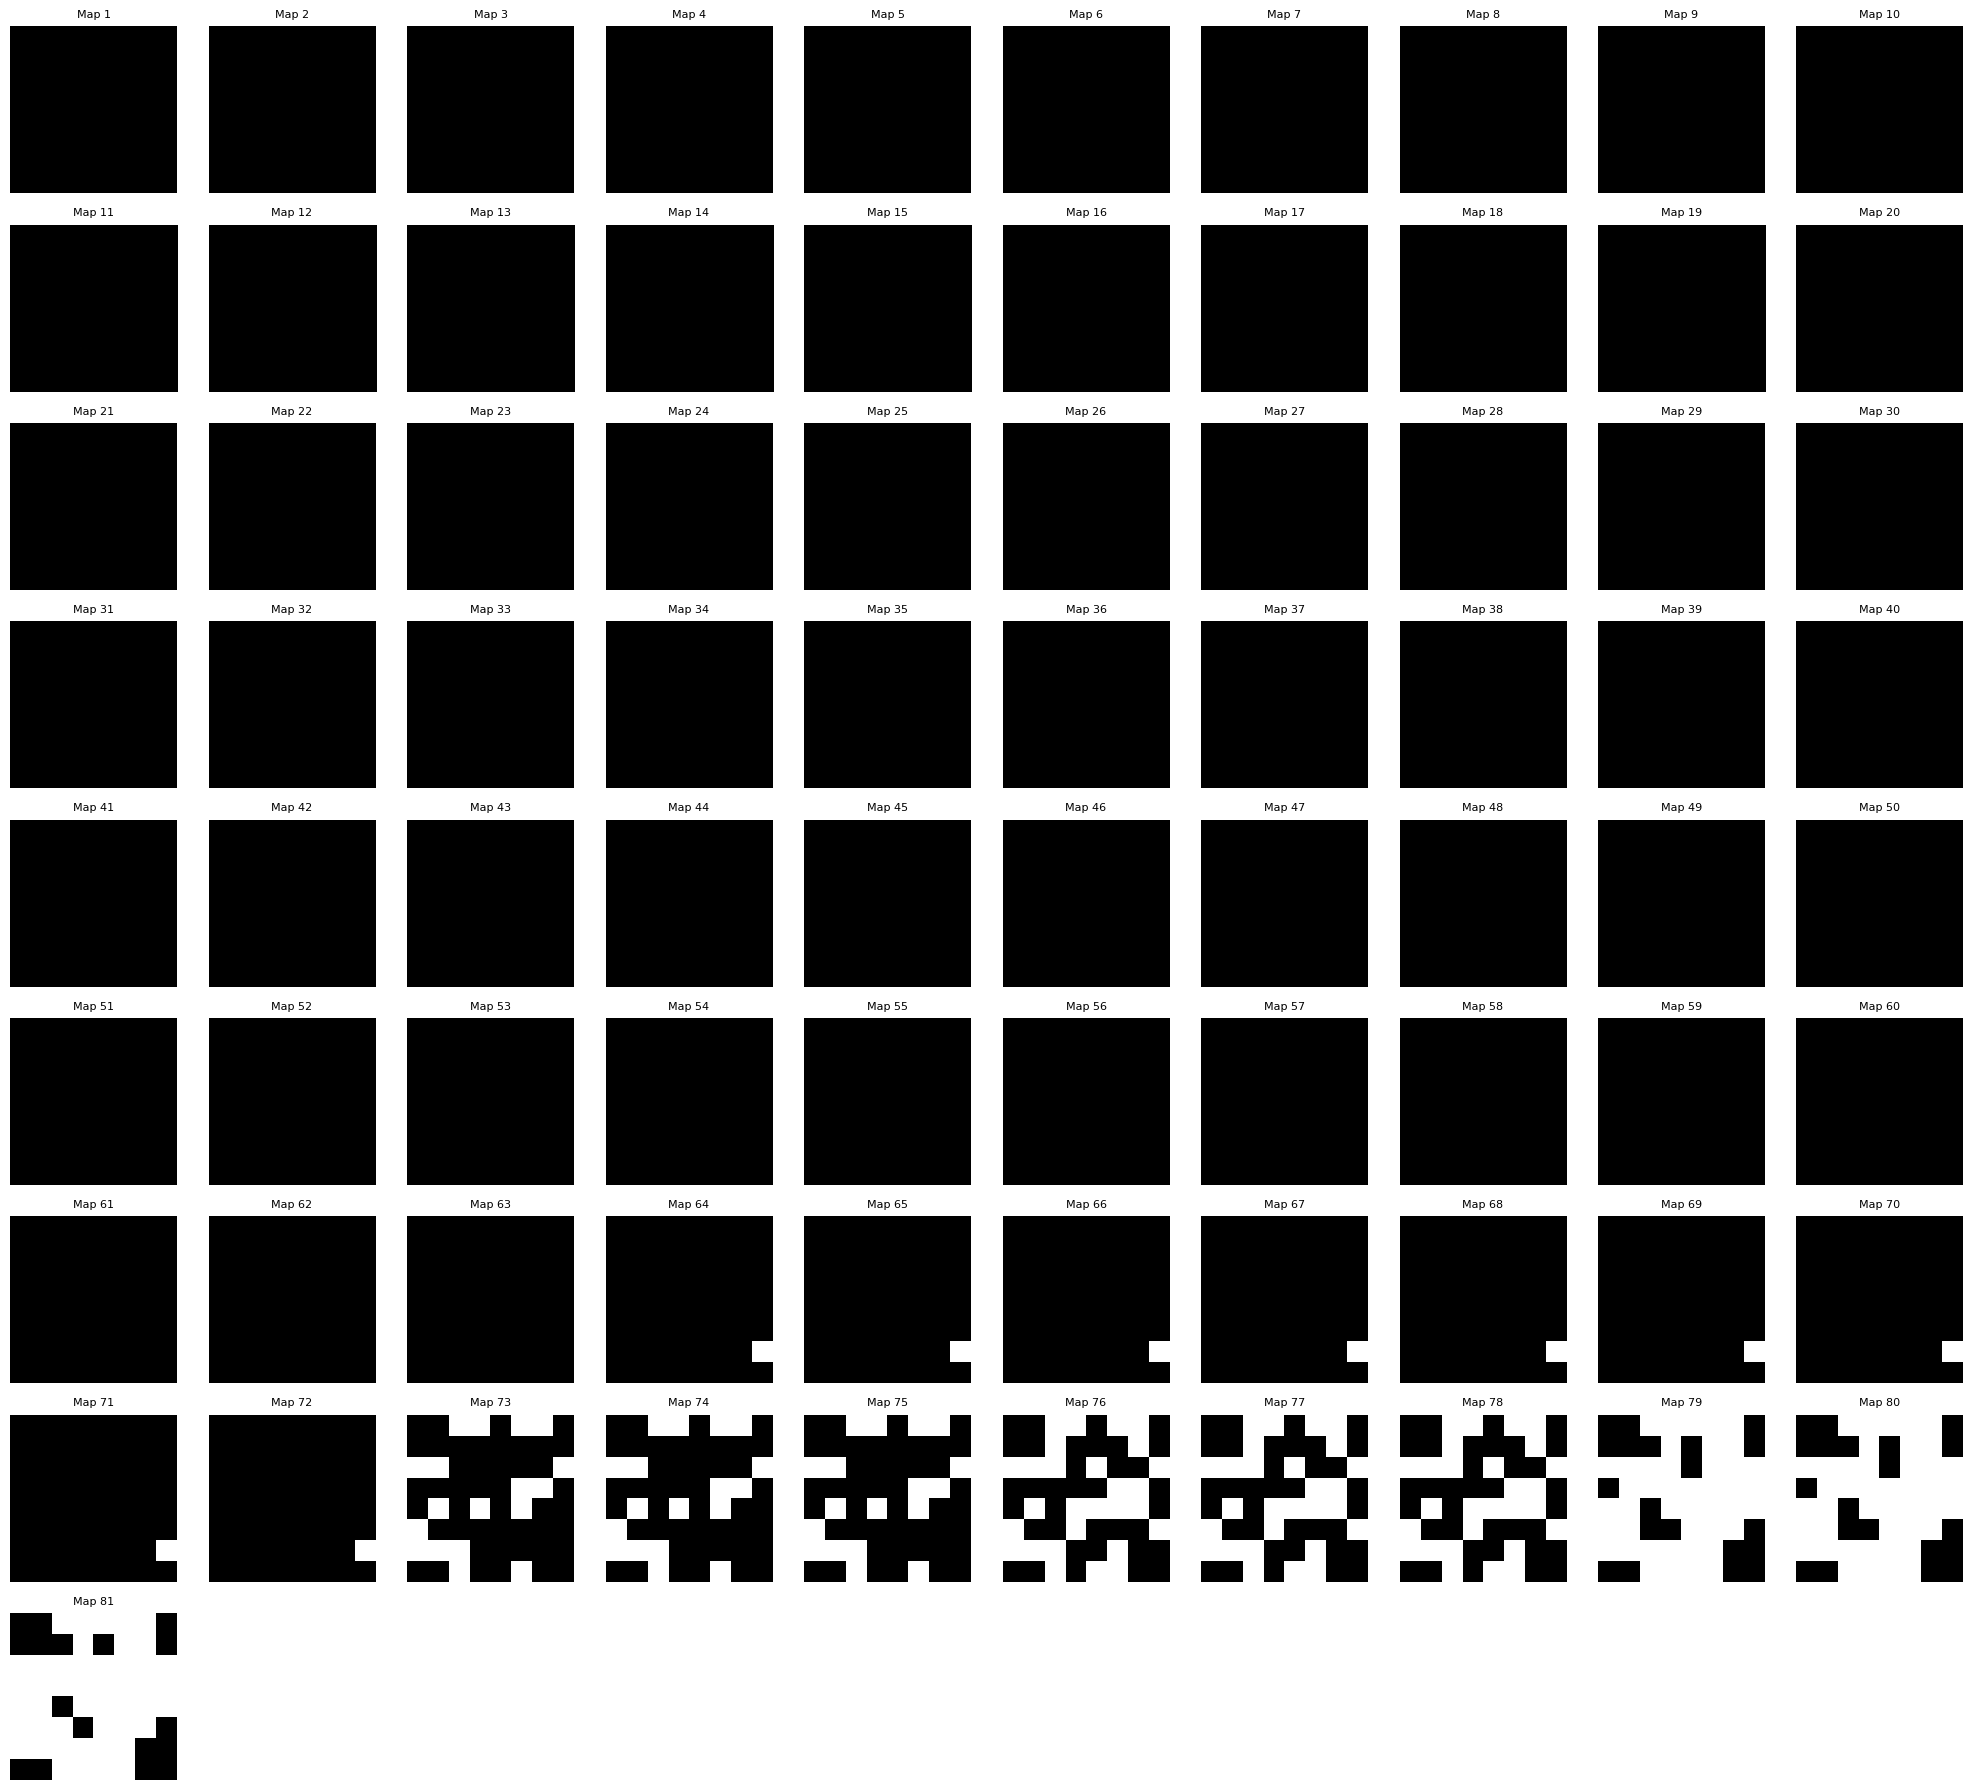

In [ ]:
def visualize_feature_maps(model, input_image, layer_name):
    """
    Visualize feature maps from a specific layer.

    :param model: Trained Keras model.
    :param input_image: Input image as a numpy array of shape (1, height, width, channels).
    :param layer_name: Name of the layer to visualize.
    """
    print(f"Initializing model for visualization from layer: {layer_name}")

    # Check if the layer exists
    try:
        layer_output = model.get_layer(layer_name).output
    except ValueError:
        available_layers = [layer.name for layer in model.layers]
        raise ValueError(
            f"Layer '{layer_name}' not found in the model. "
            f"Available layers: {available_layers}"
        )

    # Create a submodel that outputs the desired layer's activations
    submodel = tf.keras.Model(inputs=model.input, outputs=layer_output)

    # Get feature maps
    feature_maps = submodel.predict(input_image)

    # Plot feature maps
    num_maps = feature_maps.shape[-1]
    maps_per_row = 10
    num_rows = (num_maps + maps_per_row - 1) // maps_per_row  # Calculate total rows needed

    plt.figure(figsize=(maps_per_row * 2, num_rows * 2))
    for i in range(num_maps):
        plt.subplot(num_rows, maps_per_row, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap="gray")
        plt.axis("off")
        plt.title(f"Map {i + 1}", fontsize=8)
    plt.tight_layout()
    plt.show()


# Create the model
model = create_alexnet_with_ca(input_shape=(32, 32, 1), num_classes=3)

# Load a sample MNIST image
x_data, y_data = load_and_preprocess_clef(zip_file_path, target_size)
test_image = x_data[50]  # Shape: (28, 28, 1)

# Add batch dimension, shape becomes (1, 28, 28, 1)
test_image = np.expand_dims(test_image, axis=0)

# Initialize the model by calling it
_ = model(test_image)  # Ensures graph initialization

# Visualize feature maps
layer_name = "ca_layer_4"  # Use the desired layer name
visualize_feature_maps(model, test_image, layer_name)
